# EstBERT model for Estonian news portal classification

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from pathlib import Path
import time
import random
import csv

# Check if we are running on a CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!pip install transformers

In [3]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
from transformers import AutoTokenizer, PreTrainedTokenizer
from transformers import get_linear_schedule_with_warmup

In [4]:
PAD = '[PAD]'
PAD_ID = 0
DATA_PATH = Path('data')
MODEL_NAME = 'tartuNLP/EstBERT'
OUTPUTS = 6

batch_size = 16
test_split = .2
validation_split = .3
shuffle_dataset = True
random_seed = 42

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True, padding_side='right')

In [6]:
class NewsDataSet(Dataset):
    def __init__(self, pretrain_tokenizer, data_folder='.data', test=False):
        self.tokenizer = pretrain_tokenizer
        self.label_vocab =  {'elu24': 0, 'err': 1, 'paevaleht': 2, 'postimees': 3, 'telegram': 4, 'uued_uudised': 5}
        self.delimiters =  {'elu24': ';', 'err': ',', 'paevaleht': ',', 'postimees': ';', 'telegram': ',', 'uued_uudised': ','}
        self.contents_idx = {'elu24': 7, 'err': 5, 'paevaleht': 3, 'postimees': 6, 'telegram': 3, 'uued_uudised': 3}
        self.max_len = 128

        self.data_folder = data_folder
            
        self.data = []
        
        if self.data_folder.exists():
            self.load()
        else:
            raise ValueError("Data path doesn't exist!")
        
    def load(self):
        for label in ['err', 'paevaleht', 'telegram', 'uued_uudised', 'elu24', 'postimees']:
            print(f'Reading {label} articles...')
            filename = label + '_samples.csv'
            p = self.data_folder / filename
            with open(p, 'r', encoding='utf-8') as f:
                csv_reader = csv.reader(f, delimiter=self.delimiters[label])
                next(csv_reader) # header
                for row in csv_reader:
                    try:
                        row = next(csv_reader)
                        contents = row[self.contents_idx[label]]
                        if label in ['elu24', 'postimees']:
                            contents = contents.replace('|', '\n')
                        text = self.tokenizer.encode(contents, add_special_tokens=True, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
                        attention_mask = text > 0 
                        attention_mask = attention_mask.squeeze().to(torch.uint8)
                        torch_label = torch.tensor(self.label_vocab[label], dtype=torch.long)

                        self.data.append((text.squeeze(), attention_mask, torch_label))
                    except:
                        continue
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1], self.data[idx][2]

In [7]:
data = NewsDataSet(tokenizer, DATA_PATH)

Reading err articles...
Reading paevaleht articles...
Reading telegram articles...
Reading uued_uudised articles...
Reading elu24 articles...
Reading postimees articles...


In [8]:
data[0]

(tensor([    2,  1249,   570, 20355,  4882, 33451,  3452,   282, 30952,  2416,
           636,  5715,  1433,    15, 30952, 49883, 39707,    93, 20887,    36,
         20355, 49885,   555, 12327, 49886,  8707,   316,  2308,  1433,  3419,
           240,    11,   409,    42, 24931, 37010, 14820, 34090,   128,    11,
          3814,   227, 43071, 20887, 27361, 20514, 49923, 22049, 35166,    15,
         20355, 49885, 20887,    36,  3710, 39478,    25,  3936,    15,   881,
          5142, 30952,    11,    74,  1693,    42, 39399,    10,  4867,  1543,
           416, 10171,    15,    95, 20355,   633, 33744,  1685,  3976,    53,
          2645, 21366,    11,    74,   614, 12839,   930,   619,   416,  5679,
            15,   480,  6698, 20558,  1796,   316,   221,  2928, 20355,   511,
         22857,   470,  2378,  5993,  1699,    11,    82,   118, 20355, 16860,
         49882,  2261,   339, 22857, 20887,  6955,   100,   619,   614, 20355,
         49885,   638,  9479,    15,   523, 20577,  

In [9]:
# Creating data indices for training and validation splits:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
val_split = int(np.floor(validation_split * len(train_indices)))
train_indices, val_indices = train_indices[val_split:], train_indices[:val_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [10]:
train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler) 
validation_loader = DataLoader(data, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(data, batch_size=batch_size, sampler=test_sampler)

In [11]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(data.label_vocab), output_attentions=False, output_hidden_states=False)

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model.to(device)

Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are new

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The {} model has {:} different named parameters.\n'.format(MODEL_NAME, len(params)))

print('==== Embedding Layer ====\n')

emb_params = [p for p in params if 'embeddings' in p[0]]
for p in emb_params:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

first_transformer_params = [p for p in params if '.0.' in p[0]]
for p in first_transformer_params:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

cls_params = [p for p in params if 'classifier' in p[0]]
for p in cls_params:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The tartuNLP/EstBERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (50000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias   

In [14]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [15]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
# Taken from this tutorial: https://github.com/aniruddhachoudhury/BERT-Tutorials/blob/master/Blog%202/BERT_Fine_Tuning_Sentence_Classification.ipynb
# The code was modified

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed_mins, elapsed_secs = epoch_time(t0, time.time())
            
            # Report progress.
            print(f'  Batch {step:>5,}  of  {len(train_loader):>5,}.    Elapsed: {elapsed_mins:}m {elapsed_secs:}s.')

        # Unpack this training batch from our dataloader. 
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_loader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print("  Training epcoh took: {:}m {:}s".format(*epoch_time(t0, time.time())))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_loader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification
            outputs = model(b_input_ids, b_input_mask)


        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}m {:}s".format(*epoch_time(t0, time.time())))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    105.    Elapsed: 12m 4s.
  Batch    80  of    105.    Elapsed: 24m 16s.

  Average training loss: 1.13
  Training epcoh took: 31m 55s

Running Validation...
  Accuracy: 0.68
  Validation took: 4m 8s

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    105.    Elapsed: 12m 15s.
  Batch    80  of    105.    Elapsed: 24m 29s.

  Average training loss: 0.68
  Training epcoh took: 32m 8s

Running Validation...
  Accuracy: 0.74
  Validation took: 4m 8s

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    105.    Elapsed: 12m 14s.
  Batch    80  of    105.    Elapsed: 24m 28s.

  Average training loss: 0.53
  Training epcoh took: 32m 7s

Running Validation...
  Accuracy: 0.73
  Validation took: 4m 7s

Training complete!


In [21]:
print("")
print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables 
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0

final_preds = []
final_golds = []

# Evaluate data for one epoch
for batch in test_loader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification
        outputs = model(b_input_ids, b_input_mask)


    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Calculate the accuracy for this batch of test sentences.
    tmp_test_accuracy = flat_accuracy(logits, label_ids)
    final_preds.extend(logits)
    final_golds.extend(label_ids)
    
    # Accumulate the total accuracy.
    test_accuracy += tmp_test_accuracy

    # Track the number of batches
    nb_test_steps += 1

# Report the final accuracy for this test run.
print("  Accuracy: {0:.2f}".format(test_accuracy/nb_test_steps))
print("  Testing took: {:}m {:}s".format(*epoch_time(t0, time.time())))


Running Testing...
  Accuracy: 0.71
  Testing took: 3m 34s


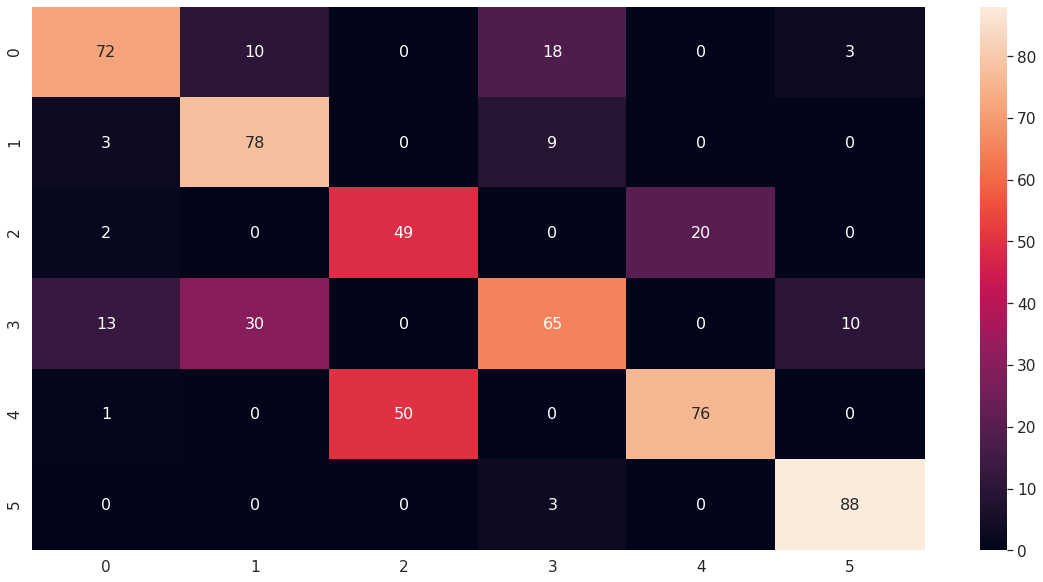

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

vocab = {0: 'elu24', 1 : 'err', 2 : 'paevaleht', 3 : 'postimees', 4 : 'telegram', 5: 'uued_uudised'}

preds = np.argmax(final_preds, axis=1).flatten().tolist()
golds = final_golds

labels = list(set(preds).union(set(golds)))

cm = confusion_matrix(preds, golds, labels=labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(20, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()

In [19]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')